In [1]:
from data_read import *
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tools import *
from evaluation import *
import random
import tensorflow as tf

#  Load the function for general purpose multiple resolution outlier removal

In [2]:
def do_range_projection_try(points,proj_H=64,proj_W=2048,fov_up=3.0,fov_down=-18.0):


    proj_range = np.full((proj_H, proj_W), -1,dtype=np.float32)

    # unprojected range (list of depths for each point)
    unproj_range = np.zeros((0, 1), dtype=np.float32)

    # projected point cloud xyz - [H,W,3] xyz coord (-1 is no data)
    proj_xyz = np.full((proj_H, proj_W, 3), -1,dtype=np.float32)

   

    # projected index (for each pixel, what I am in the pointcloud)
    # [H,W] index (-1 is no data)
    proj_idx = np.full((proj_H, proj_W), -1,
                            dtype=np.int32)

    # for each point, where it is in the range image
    proj_x = np.zeros((0, 1), dtype=np.float32)        # [m, 1]: x
    proj_y = np.zeros((0, 1), dtype=np.float32)        # [m, 1]: y

    # mask containing for each pixel, if it contains a point or not
    proj_mask = np.zeros((proj_H, proj_W),dtype=np.int32) 
    
    
    # laser parameters
    fov_up = fov_up / 180.0 * np.pi      # field of view up in rad
    fov_down = fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # get field of view total in rad

    # get depth of all points
    depth = np.linalg.norm(points, 2, axis=1)


    # get scan components
    scan_x = points[:, 0]
    scan_y = points[:, 1]
    scan_z = points[:, 2]

    # get angles of all points
    yaw = -np.arctan2(scan_y, scan_x)
    pitch = np.arcsin(scan_z / depth)

    # get projections in image coords
    proj_x = 0.5 * (yaw / np.pi + 1.0)          # in [0.0, 1.0]
    
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov        # in [0.0, 1.0]
    return proj_x,proj_y

    
def outlier_removal_mask(lidar,line_num=64,height_offset=100):

    height,width=np.shape(np.squeeze(lidar))

    height_bin=np.round((height-height_offset)/line_num-1)
    width_bin=np.round(width*line_num/(np.sum(lidar>0.1))-1)

        
    total_points,x_indices,y_indices,width_image,height_image=get_all_points(lidar,intrinsic)
    proj_x,proj_y=do_range_projection_try(total_points)

    project_x=np.zeros((height,width))
    project_y=np.zeros((height,width))
    project_x[y_indices,x_indices]=proj_x
    project_y[y_indices,x_indices]=proj_y


    lidar_pre=np.expand_dims(np.squeeze(lidar),axis=0)
    lidar_pre=np.expand_dims(lidar_pre,axis=-1)
    lidar_trunck=tf.image.extract_patches(images=lidar_pre,sizes=[1, height_bin*2+1, width_bin*2+1, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='SAME')

    
    expand_size=(height_bin*2+1)*(width_bin*2+1)
    expand_size=np.int32(expand_size)
    lidar_pre_expand=tf.tile(lidar_pre.astype(np.float32),[1,1,1,expand_size])
         

    project_x_pre=np.expand_dims(np.squeeze(project_x),axis=0)
    project_x_pre=np.expand_dims(project_x_pre,axis=-1)
    project_x_trunck=tf.image.extract_patches(images=project_x_pre,sizes=[1, height_bin*2+1, width_bin*2+1, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='SAME')

    project_y_pre=np.expand_dims(np.squeeze(project_y),axis=0)
    project_y_pre=np.expand_dims(project_y_pre,axis=-1)
    project_y_trunck=tf.image.extract_patches(images=project_y_pre,sizes=[1, height_bin*2+1, width_bin*2+1, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='SAME')

    height_image_pre=np.expand_dims(np.squeeze(height_image).astype(np.double),axis=0)
    height_image_pre=np.expand_dims(height_image_pre,axis=-1)
    height_image_trunck=tf.image.extract_patches(images=height_image_pre,sizes=[1, height_bin*2+1, width_bin*2+1, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='SAME')

    width_image_pre=np.expand_dims(np.squeeze(width_image).astype(np.double),axis=0)
    width_image_pre=np.expand_dims(width_image_pre,axis=-1)
    width_image_trunck=tf.image.extract_patches(images=width_image_pre,sizes=[1, height_bin*2+1, width_bin*2+1, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='SAME')


    lidar_residual=lidar_pre-lidar_trunck
        
        
    project_x_residual=project_x_pre-project_x_trunck
    project_y_residual=project_y_pre-project_y_trunck
    height_image_residual=height_image_pre-height_image_trunck
    width_image_residual=width_image_pre-width_image_trunck
    zero_mask=np.logical_and(lidar_pre_expand>0.1,lidar_trunck>0.1)

    x_mask_1=np.logical_and(project_x_residual>0.0000,width_image_residual<=0)
    x_mask_2=np.logical_and(project_x_residual<0.0000,width_image_residual>=0)
    x_mask=np.logical_or(x_mask_1,x_mask_2)
    x_mask=np.logical_and(x_mask,zero_mask)
        
    y_mask_1=np.logical_and(project_y_residual>0,height_image_residual<=0)
    y_mask_2=np.logical_and(project_y_residual<0,height_image_residual>=0)
    y_mask=np.logical_or(y_mask_1,y_mask_2)
    y_mask=np.logical_and(y_mask,zero_mask)
        
    
        
    lidar_mask=np.logical_and(lidar_residual>3.0,lidar_pre>0.01)

    final_mask=np.logical_and(lidar_mask,np.logical_or(x_mask,y_mask))    
    final_mask=np.squeeze(final_mask)
    final_mask=np.sum(final_mask,axis=-1)
    final_mask=np.expand_dims(final_mask>0,axis=0)
    return final_mask



# Assign a sample number 

In [3]:
i=25
img,lidar,gt,intrinsic= read_one_val(i)

A=calculate_normal()

# Visualize identified outliers

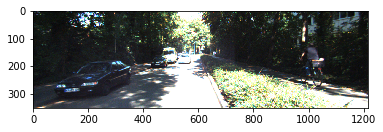

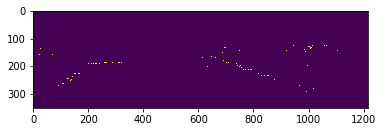

In [4]:
outlier_mask=outlier_removal_mask(np.copy(lidar))
plt.imshow(np.squeeze(img))
plt.show()
plt.imshow(np.squeeze(outlier_mask))
plt.show()

# Calculate normal on spherical and map normal on image plane

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


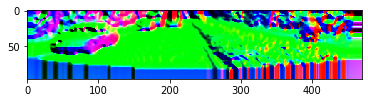

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


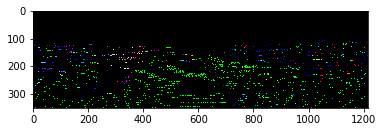

In [5]:
px,py,fx,fy=construct_px_py_fx_fy(lidar,intrinsic)
lidar_new=lidar*(1.0-outlier_mask)

total_points,x_indices,y_indices,width_image,height_image=get_all_points(lidar_new,intrinsic)

range_image,proj_xyz,proj_idx,proj_mask=do_range_projection(total_points)
range_image_new=fill_spherical(range_image)
normal_spherical=A.calculate_normal(range_image_new)
normal_img=put_normal_on_image(normal_spherical,x_indices,y_indices,proj_idx,proj_mask)


plt.imshow(normal_spherical)
plt.show()

plt.imshow(normal_img)
plt.show()

# Distance transform to fill in nearest depth and normal for each pixel

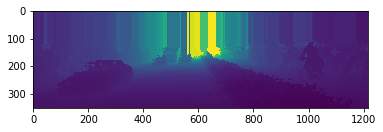

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


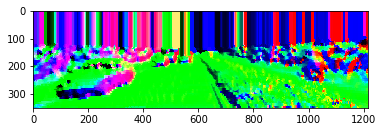

In [7]:
a=normal_img[:,:,0]
b=normal_img[:,:,1]
c=normal_img[:,:,2]
depth_map,a_list_all,b_list_all,c_list_all,height_list_offset,width_list_offset=Distance_Transform_Normal(lidar_new,a,b,c,width_image,height_image)


plt.imshow(depth_map)
plt.show()

normal_on_img=np.asarray([a_list_all,b_list_all,c_list_all])
normal_on_img=np.transpose(normal_on_img,[1,2,0])
plt.imshow(normal_on_img)
plt.show()


# Set a threshold for extreme values, use the equation to do the completion

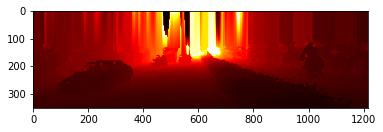

In [10]:
threshold=0.1

upper=(width_list_offset/fx*a_list_all+height_list_offset/fy*b_list_all)
lower=(width_image-px)/fx*a_list_all+(height_image-py)/fy*b_list_all+c_list_all

lower[np.logical_and(np.abs(lower)<threshold,lower>0)]=threshold
lower[np.logical_and(np.abs(lower)<threshold,lower<0)]=-threshold
residual=upper/lower

depth_predicted=depth_map+residual*depth_map
    
kernelx=self_gaussian(kernel_size=9,g_range=3.5)
depth_predicted = cv2.filter2D(depth_predicted, -1, kernelx)
depth_predicted=np.squeeze(lidar_new)+depth_predicted*(1.0-np.squeeze(lidar_new)>0.01)
depth_predicted[depth_predicted<0.9]=0.9
depth_predicted[depth_predicted>80.0]=80.0
    
plt.imshow(depth_predicted,cmap='hot')
plt.show()